This notebook revisits the analysis of Andrei, Mann, and Moyen (JFE 2019). There are two companion notebooks to this one:

**AMM2019 - Archived data.ipynb** matches exactly the results in our published paper, using data that we downloaded and archived at the time.

The current notebook follows the same algorithm, but downloads the data directly from FRED via API, instead of importing our archived data files. This results in code that can be dynamically updated over time, reflecting both newer data releases and revisions to historical figures. Due to revisions, the results of this code will not exactly match our published paper.

**AMM2019 - FRED API data - simplified.ipynb** then shows that our qualitative conclusions can be seen with a much simpler approach that skips over many of the steps from Hall (2001) and focuses attention on the most important patterns in the data. This simplified approach is also closer in spirit to most analysis with Compustat data, which typically does not attempt to adjust for inflation or the difference between book values and market values of debt.

# Import packages

In [1]:
import fredapi
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from dotenv import load_dotenv
load_dotenv();

# Download data from FRED

Import FRED API key and initiate session.

If you run this code on your own machine, substitute your own API key string in the first line.

In [2]:
Fred_session = fredapi.Fred()

Set beginning and end dates to use in data downloads.

In [3]:
first_obs = '1951-01-01'
last_obs = '2022-12-31'

BEA: Aggregate annual current-cost net-stock of private nonresidential fixed assets, and aggregate quarterly private nonresidential fixed investment (seasonally adjusted at annual rate) reported in NIPA tables.

- The latter figure is reported in billions in the raw data.

In [4]:
net_capital = Fred_session.get_series('K1NTOTL1ES000', observation_start = first_obs, observation_end = last_obs)
PNFI        = 1e3*Fred_session.get_series('PNFI', observation_start = first_obs, observation_end = last_obs)

NIPA price index for private fixed nonresidential investment:

In [5]:
Deflator    = (1/100)*Fred_session.get_series('A008RD3Q086SBEA', observation_start = first_obs, observation_end = last_obs)

The next two series break out BEA data on IP investment and assets separately from the aggregate figures. These categories were added to the BEA figures in 2013, so the series can be useful in reconciling pre-2013 analysis, although we do not pursue that here.

In [6]:
PNFI_IP     = 1e3*Fred_session.get_series('Y001RC1Q027SBEA', observation_start = first_obs, observation_end = last_obs)
IP_capital  = Fred_session.get_series('K1NTOTL1IP000', observation_start = first_obs, observation_end = last_obs)

Flow of funds: Financial value of corporate business

- The equity series is reported in millions, the other three in billions.

In [7]:
Equity      = Fred_session.get_series('NCBEILQ027S', observation_start = first_obs, observation_end = last_obs)
Liabilities = 1e3*Fred_session.get_series('TLBSNNCB', observation_start = first_obs, observation_end = last_obs)
FinAssets   = 1e3*Fred_session.get_series('TFAABSNNCB', observation_start = first_obs, observation_end = last_obs)
Inventories = 1e3*Fred_session.get_series('A373RC1Q027SBEA', observation_start = first_obs, observation_end = last_obs)

Flow of funds: Gross fixed investment in nonresidential structures, equipment, and intellectual property products by nonfinancial corporate business.

In [8]:
gross_investment = Fred_session.get_series('BOGZ1FU105013005Q', observation_start = first_obs, observation_end = last_obs)

Flow of funds: Issuance, stock, and yields of taxable and tax-exempt corporate bonds.

In [9]:
Bonds_issuance_taxable = (1/4)*Fred_session.get_series('NCBCBLQ027S', observation_start = first_obs, observation_end = last_obs)
Bonds_outstanding_taxable = 1e3*Fred_session.get_series('CBLBSNNCB', observation_start = first_obs, observation_end = last_obs)

yield_taxable = (1/100)*Fred_session.get_series('BAA', observation_start = first_obs, observation_end = last_obs,frequency='m')
yield_taxable=yield_taxable.resample('QE').first()

Bonds_issuance_exempt = (1/4)*Fred_session.get_series('NCBSLLQ027S', observation_start = first_obs, observation_end = last_obs)
Bonds_outstanding_exempt = 1e3*Fred_session.get_series('MSLBSNNCB', observation_start = first_obs, observation_end = last_obs)

yield_exempt = (1/100)*Fred_session.get_series('WSLB20', observation_start = first_obs, observation_end = last_obs,frequency='m')
yield_exempt=yield_exempt.resample('QE').first()

Reset all monthly datetime indexes to the correct frequency:

In [10]:
# Quarterly:
Equity      = Equity.set_axis(Equity.index.to_period('Q'))
Liabilities = Liabilities.set_axis(Liabilities.index.to_period('Q'))
FinAssets   = FinAssets.set_axis(FinAssets.index.to_period('Q'))
Inventories = Inventories.set_axis(Inventories.index.to_period('Q'))
PNFI        = PNFI.set_axis(PNFI.index.to_period('Q'))
gross_investment = gross_investment.set_axis(gross_investment.index.to_period('Q'))
Deflator    = Deflator.set_axis(Deflator.index.to_period('Q'))
yield_taxable = yield_taxable.set_axis(yield_taxable.index.to_period('Q'))
yield_exempt = yield_exempt.set_axis(yield_exempt.index.to_period('Q'))
Bonds_issuance_taxable = Bonds_issuance_taxable.set_axis(Bonds_issuance_taxable.index.to_period('Q'))
Bonds_outstanding_taxable = Bonds_outstanding_taxable.set_axis(Bonds_outstanding_taxable.index.to_period('Q'))
Bonds_issuance_exempt = Bonds_issuance_exempt.set_axis(Bonds_issuance_exempt.index.to_period('Q'))
Bonds_outstanding_exempt = Bonds_outstanding_exempt.set_axis(Bonds_outstanding_exempt.index.to_period('Q'))
# Annual:
net_capital = net_capital.set_axis(net_capital.index.to_period('Y'))

# Process data to construct investment rate and Tobin's Q

## Hall (2001) algorithm for approximating the market value of outstanding bonds:

- Assume all bonds are issued at par with a ten year lifespan, one coupon each four quarters, and YTM equal to the BAA index for taxable bonds or the BBI Go 20 index for tax-exempt.
- Each quarter, the gross amount of debt issued in this manner is this quarter's recorded net issuance, plus any net issuance ten years ago (40 quarters ago). (To see why we add them together, imagine that the maturing debt from ten years ago was simply paid off. Then net issuance today would be exactly the negative of net issuance ten years ago and gross is zero.)
- The associated coupon is today's gross issuance times today's prevailing yield.
- Finally, for any given quarter, we project the *future* cash flows from the corporate sector to investors associated with the *existing* stock of debt at this quarter. These cash flows will be the sum of coupons and principal repayments on past issuance. Since we assume a ten-year maturity on all debt, at any moment we have only 40 future quarters to consider.
- Discount all cash flows projected during those 40 quarters at today's prevailing yield. The result of that DCF is today's market value of bonds outstanding.

Apply the above algorithm for **taxable** corporate bonds:

In [11]:
# Calculate gross issuance during any quarter
Bonds_issuance_taxable_gross = Bonds_issuance_taxable + Bonds_issuance_taxable.shift(40).fillna(0)
# Coupon associated with each quarter's gross issuance, will apply to the next 40 quarters
Coupon_issued_taxable = yield_taxable*Bonds_issuance_taxable_gross
# Create an empty dataframe to hold the cash flows over the next 40 quarters starting from any date
Cashflows_taxable = pd.DataFrame(index = Coupon_issued_taxable.index)
for future_quarter in range(1,41):
    # Repayment of principal from 40 quarters prior to this future one:
    Cashflows_taxable[future_quarter] = Bonds_issuance_taxable_gross.shift(40-future_quarter).fillna(0)
    # Coupon payments associated with debt from before today, only in increments of 4 quarters:
    for quarterlag in range( 4*math.ceil(future_quarter/4) , 41, 4):
        Cashflows_taxable[future_quarter] += Coupon_issued_taxable.shift(quarterlag-future_quarter).fillna(0)
# Create another dataframe to hold the outcome of all this
Bonds_BV_taxable = Bonds_outstanding_taxable
Bonds_MV_taxable = pd.DataFrame(index = Bonds_BV_taxable.index)
Bonds_MV_taxable['MV'] = 0
for future_quarter in range(1,41):
    Bonds_MV_taxable['MV'] += Cashflows_taxable[future_quarter] / (1+yield_taxable)**(future_quarter/4)
# Convert dataframe back to series
Bonds_MV_taxable = Bonds_MV_taxable['MV']

Apply the above algorithm for **tax-exempt** corporate bonds:

In [12]:
# Fill in Bond Buyer index after it was discontinued in 2016Q3 with approximation 0.7*BBA
# This approximation is good in-sample, but is obviously not an ideal long-term approach.
# This category of bonds is very small in the data so we wouldn't lose much by just leaving them at book value.
yield_exempt = pd.concat( [ yield_exempt[:'2016Q3'] , 0.7*yield_taxable['2016Q4':] ] )

# Calculate gross issuance during any quarter
Bonds_issuance_exempt_gross = Bonds_issuance_exempt + Bonds_issuance_exempt.shift(40).fillna(0)
# Coupon associated with each quarter's gross issuance, will apply to the next 40 quarters
Coupon_issued_exempt = yield_exempt*Bonds_issuance_exempt_gross
# Create an empty dataframe to hold the cash flows over the next 40 quarters starting from any date
Cashflows_exempt = pd.DataFrame(index = Coupon_issued_exempt.index)
for future_quarter in range(1,41):
    # Repayment of principal from 40 quarters prior to this future one:
    Cashflows_exempt[future_quarter] = Bonds_issuance_exempt_gross.shift(40-future_quarter).fillna(0)
    # Coupon payments associated with debt from before today, only in increments of 4 quarters:
    for quarterlag in range( 4*math.ceil(future_quarter/4) , 41, 4):
        Cashflows_exempt[future_quarter] += Coupon_issued_exempt.shift(quarterlag-future_quarter).fillna(0)
Bonds_BV_exempt = Bonds_outstanding_exempt
Bonds_MV_exempt = pd.DataFrame(index = Bonds_BV_exempt.index)
Bonds_MV_exempt['MV'] = 0
for future_quarter in range(1,41):
    Bonds_MV_exempt['MV'] += Cashflows_exempt[future_quarter] / (1+yield_exempt)**(future_quarter/4)
# Convert dataframe back to series
Bonds_MV_exempt = Bonds_MV_exempt['MV']

## Calculate investment and investment rate, enterprise value, and Q.

Calculate aggregate enterprise value of nonfinancial corporate business (the numerator of Tobin's Q).

In [13]:
EnterpriseValue = Equity + Liabilities - FinAssets - Inventories + (Bonds_MV_taxable - Bonds_BV_taxable) + (Bonds_MV_exempt - Bonds_BV_exempt)

Deflate investment, enterprise value, and end-of-year net capital stock to real values.

In [14]:
PNFI_real = PNFI / Deflator
EnterpriseValue_real = EnterpriseValue / Deflator
net_capital_real = net_capital / Deflator.resample('Y').last()

For the denominator of the investment rate, Hall uses the BEA's current-cost net stock of private nonresidential fixed assets, which we imported above. This number is only reported at the end of each year, so interpolate it linearly to the other three quarters of each year.

In [15]:
net_capital_real_smooth = net_capital_real.resample('Q').interpolate().shift(3)

For the denominator of Tobin's Q, Hall calculates a different capital stock by starting with the BEA's net capital stock for 1951, then accumulating the investment figures reported in the Flow of Funds data, and depreciating them at an annualized rate of 10%. All these quantities are first deflated with the same NIPA investment deflator as elsewhere in the analysis.

In [16]:
annual_depreciation = 0.1
quarterly_depreciation = 1-(1-0.1)**(0.25)
real_investment = gross_investment / Deflator
replacement_cost = net_capital_real_smooth.copy()
replacement_cost[:] = math.nan
replacement_cost.loc['1951Q4'] = net_capital_real_smooth.loc['1951Q4']
for indexval in replacement_cost['1952Q1':].index:
    replacement_cost.loc[indexval] = (1-quarterly_depreciation)*replacement_cost.loc[indexval-1] + real_investment.loc[indexval]

Calculate investment rate and Tobin's Q.

- Investment rate is investment during a quarter divided by stock of capital from the end of last quarter.
- Tobin's Q is enterprise value at the end of a quarter divided by capital stock at the end of the quarter.
- Due to this timing, in our analysis we compare the investment rate for a given quarter with *lagged* Tobin's Q.

In [17]:
ik = PNFI_real / net_capital_real_smooth.shift()
Q = EnterpriseValue_real / replacement_cost

## Visualizations of the aggregate investment-Q relationship
Compared with Figures 1 and 2 of the published paper, these are updated beyond the end of 2015 and also incorporate any revisions to the historical data since then.

Investment and lagged Q in levels (compare with figure 1 in the paper):

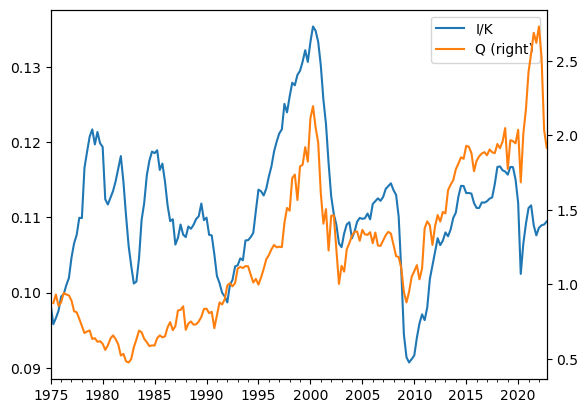

In [18]:
ik['1975Q1':].plot(legend=True,label="I/K");
Q['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);

Investment and lagged Q as year-over-year differences (compare with Figure 2 of the published paper):

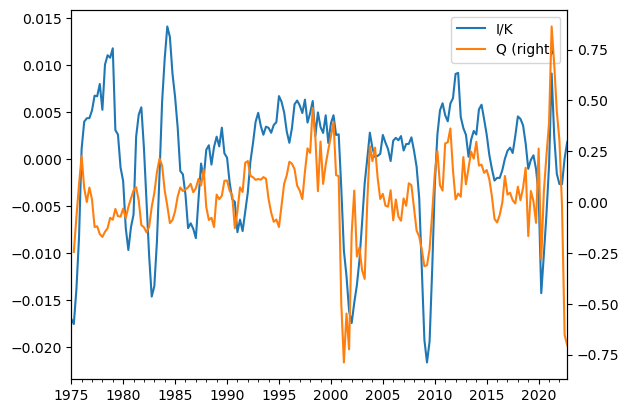

In [19]:
ik.diff(4)['1975Q1':].plot(legend=True,label="I/K");
Q.diff(4)['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);

Investment and lagged Q as simple differences (not year-over-year): This was not in the published paper. It perhaps illustrates even more clearly the intuition that Q has become more volatile in recent decades.

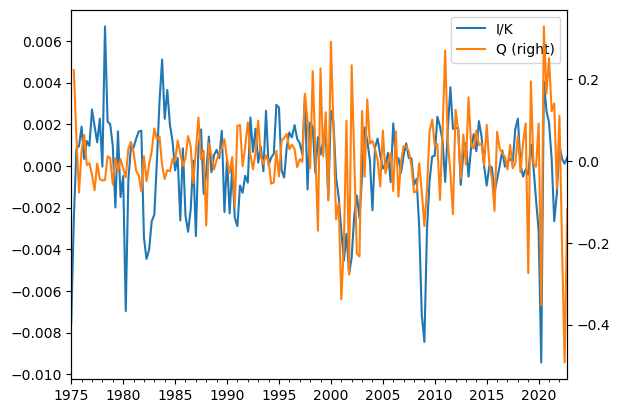

In [20]:
ik.diff()['1975Q1':].plot(legend=True,label="I/K");
Q.diff()['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);